# CICIDS2017 Data Engineering Project

**End-to-end data pipeline on CICIDS2017 intrusion detection dataset- includes cleaning, feature engineering, and generation security KPIs**

Dataset: [CICIDS2017](https://www.unb.ca/cic/datasets/ids-2017.html)

**Loaded CICIDS2017 csv file - ~225l rows and 85 columns**

In [124]:
# Load & Explore the Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

file_path="C:/Users/2247823/OneDrive - TCS COM PROD/Datasets/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

df=pd.read_csv(file_path,low_memory=False)

print('Shape:',df.shape)
print('Cloumns:',df.columns.tolist())

Shape: (225745, 85)
Cloumns: ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length 

In [125]:
## Data Exploration & Column Analysis

df.head(3)

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


**Cleaned column names by removing spaces and special charachters**


In [126]:
# Check Column Names & Clean them 
# Clean column names: remove leading/trailing spaces, replace, spaces with underscores

df.columns=df.columns.str.strip().str.replace(' ','_').str.replace('/','_').str.replace('-','_')


In [127]:
df.columns[:10].tolist()

['Flow_ID',
 'Source_IP',
 'Source_Port',
 'Destination_IP',
 'Destination_Port',
 'Protocol',
 'Timestamp',
 'Flow_Duration',
 'Total_Fwd_Packets',
 'Total_Backward_Packets']

**Checked for null and datatype issues**

In [128]:
# Check for missing values

missing_values=df.isnull().sum()
missing_values[missing_values >0].sort_values(ascending=False)


Flow_Bytes_s    4
dtype: int64

In [129]:
# clean the dataset
df['Flow_Bytes_s'].head(4)

0    4.000000e+06
1    1.100917e+05
2    2.307692e+05
3    3.529412e+05
Name: Flow_Bytes_s, dtype: float64

**Fill with the median of 4 missing rows in Flow_Bytes_s and handled infinite values**

In [130]:
# fill with median

median_val=df['Flow_Bytes_s'].median()
df['Flow_Bytes_s'].fillna(median_val, inplace=True)

In [131]:
df['Flow_Bytes_s'].dtype

dtype('float64')

In [132]:
print("Missing after fill:", df['Flow_Bytes_s'].isnull().sum())

Missing after fill: 0


In [133]:
# Check Column Data Types

df.dtypes.value_counts()

int64      56
float64    24
object      5
dtype: int64

In [134]:
# handle infinite values
import numpy as np

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [135]:
# strip and clean string columns

df['Label']=df['Label'].str.strip()

In [136]:
df['Label']=df['Label'].astype('category')

In [137]:
# convert Numeric Columns

obj_col=df.select_dtypes(include=object).columns.tolist()

for col in obj_col:
    try:
        df[col]=pd.to_numeric(df[col])
    except:
        pass 


In [138]:
df.dtypes.value_counts()

int64       56
float64     24
object       4
category     1
dtype: int64

In [139]:
# save cleaned data

df.to_csv("C:/Users/2247823/OneDrive - TCS COM PROD/Datasets/TrafficLabelling/cleaned_friday_ddos.csv", index=False)

***Engineering new flow-level metrics to support security analysis***

In [140]:
## basic summary of KPIs


# 1.total number of records
total_records=len(df)

# 2.Unique source ips
unique_src_ips=df['Source_IP'].nunique()

# 3.total flow by protocol
flows_by_protocol=df['Protocol'].value_counts()

# 4.count of benign vs attacks
label_counts=df['Label'].value_counts()


print("Total Records:", total_records)
print("Unique source IPs:",unique_src_ips)
print("Flows by Protocol:\n", flows_by_protocol)
print("Traffic Labels:\n", label_counts)

Total Records: 225711
Unique source IPs: 2067
Flows by Protocol:
 6     192786
17     32871
0         54
Name: Protocol, dtype: int64
Traffic Labels:
 DDoS      128025
BENIGN     97686
Name: Label, dtype: int64


In [141]:
# create new features

# Feature 1: Byte Ratio between forward and backword packet
# 1 Byte ration(fwd/bwd) - indicate data imbalance
df['Byte_Ratio']=df['Total_Length_of_Fwd_Packets']/(df['Total_Length_of_Bwd_Packets']+1)

In [142]:
# Feature 2: Flow Intensity= Packet rate * Byte rate
# flow intensity

df['Flow_Intensity']=df['Flow_Packets_s']*df['Flow_Bytes_s']

In [143]:
# Feature 3: Total number of packets in flow
# Total Packet Count

df['Total_Packets']=df['Total_Fwd_Packets']+df['Total_Backward_Packets']

In [144]:
# feature 4: Flow duration in seconds
# duration in Seconds

df['Flow_Duration_Seconds']=df['Flow_Duration']/1000000

**Enginerring 4 key featured for deeper flow-level analysis**

In [145]:
# Grouped KPIs (agg view)

# total flows per local (benign vs attack)
flows_by_label=df.groupby('Label').size().sort_values(ascending=False)

# average flow duration by label
avg_duration_by_label=df.groupby('Label')['Flow_Duration_Seconds'].mean().sort_values(ascending=False)


# average packets per flow by protocol
avg_packets_by_protocol=df.groupby('Protocol')['Total_Packets'].mean().sort_values(ascending=False)


In [163]:
# Visualizing flow labels to compare attack traffice against normal
# top 10 Ips generating the most attack flows

attack_df=df[df['Label']!="Benign"]
top_attack_ips=attack_df['Source_IP'].value_counts().head(10)


In [164]:
# Save featured- egineered Data
# Exported cleaned and feature-rich dataset for modeling or further analysis

df.to_csv("C:/Users/2247823/OneDrive - TCS COM PROD/Datasets/TrafficLabelling/enriched_friday_ddos.csv", index=False)

***Security Visualization & Data Insights***

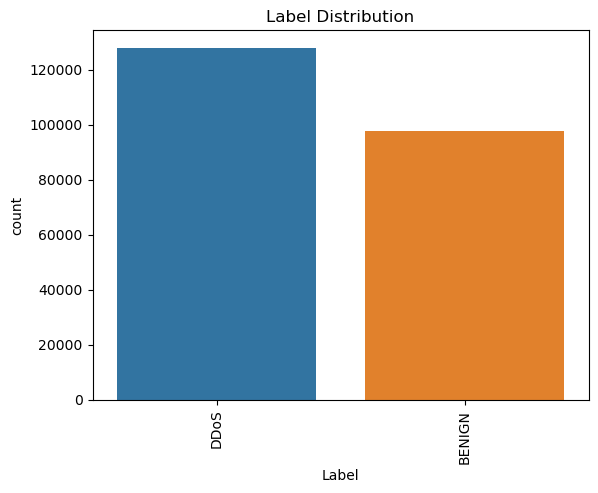

In [148]:
# Label Distribution ( Benign vs Attack)

sns.countplot(data=df, x='Label',
    order=df['Label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Label Distribution")
plt.show()

***Above output Label Distributio which shows class imbalance between BENIGN and various attack types.***

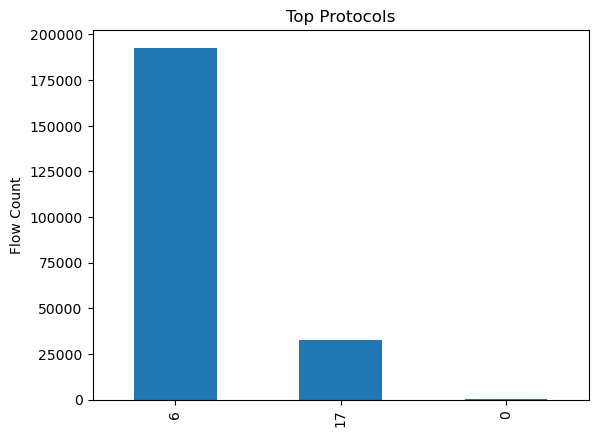

In [149]:
# Top Protocols Used

df['Protocol'].value_counts().head(10).plot(kind='bar', title='Top Protocols')
plt.ylabel('Flow Count')
plt.show()

***Above output Top Protocol Used, identifies most frequent protocols involved in flows.***

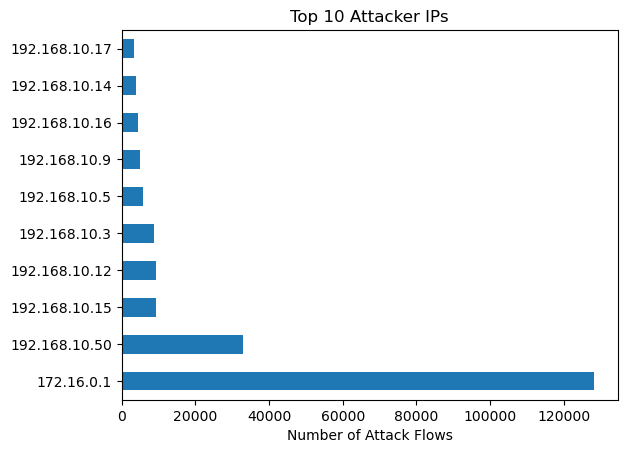

In [169]:
# top 10 attacker IPs

attack_df['Source_IP'].value_counts().head(10).plot(kind='barh',title='Top 10 Attacker IPs')
plt.xlabel("Number of Attack Flows")
plt.show()

***Above Output - Top 10 Attacker IPs, Highlights source IPs generating maximum attack traffic***

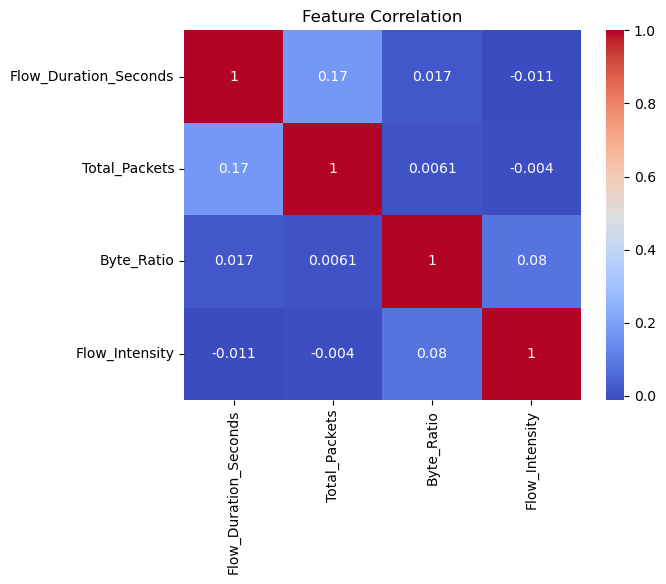

In [170]:
# Correlation Heatmap of Engineered Features

numeric_cols=['Flow_Duration_Seconds','Total_Packets','Byte_Ratio','Flow_Intensity']
sns.heatmap(df[numeric_cols].corr(),annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

***Above Output- Correlation Heatmap, Displays relationships between key engineered featured for better feature selection***

#### Project Summary 

- Worked on CICIDS2017 intrusion detection dataset to simulate a real-world data engineering pipeline.
- Performed data wrangling, handled null/infinite values, and cleaned column names
- Engieering key featured like Byte Ratio, flow intensity and total packets for deeper flow-level insights.
- Created Security-specific visualizations such as label distribution, top attacker IPs and protocol usage.
- Exported the cleaned and enriched dataset for use in ML models or BI dashboards.